# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: part of sphere classification

This demo uses the whole datataset, smoothing, and the addition of noise.

**You need a private dataset to execute this notebook.**
See the [README](https://github.com/SwissDataScienceCenter/DeepSphere/tree/master#reproducing-the-results-of-the-paper).
But you can use it with your own data.

### 0.1 Load packages

In [94]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import shutil

# Run on first GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# To get the CUDA profiler (do it on the CLI before starting jupyter):
# export LD_LIBRARY_PATH=/usr/local/cuda-9.0/extras/CUPTI/lib64

import numpy as np
import matplotlib.pyplot as plt

from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)

### 0.2 Definition of the parameters

#### A) Non tunable parameters
These parameters are fixed or the preprocessing script has to be modified.

In [4]:
Nside = 1024
sigma = 3
data_path = '/mnt/scratch/lts2/mdeff/deepsphere/data/same_psd/'
# data_path = 'data/same_psd/'

#### B) Tunable parameters
These parameters can be changed.

We choose to work in the noiseless setting by setting `sigma_noise = 0`. This allows this notebook to run an acceptable time. In the noisy case, the training of the network needs considerably more iterations.

In [5]:
order = 1  # 1,2,4,8 correspond to 12,48,192,768 parts of the sphere.
sigma_noise = 2  # Amount of noise for the experiment

# 1 Data preparation

### 1.1 Data download
Set `download` to `True` to download the dataset from zenodo

In [6]:
download = False
if download:
    %run -i 'download.py'

### 1.2 Data preprocessing
Apply the preprocessing steps.
1. Remove the mean of the maps
2. Smooth with a radius of 3 arcmin. (`sigma` parameter)

Set `preprocess` to `True` to execute the preprocessing script.

In [6]:
preprocess = False
if preprocess:
    %run -i 'data_preprocess.py'

Let us display the resulting PSDs of the preprocessed data. We pre-computed the PSDs for faster execution.

compute = False
if compute:
    psd = experiment_helper.psd
    data_path = 'data/same_psd/'
    ds1 = np.load(data_path+'smoothed_class1_sigma{}.npz'.format(sigma))['arr_0']
    ds2 = np.load(data_path+'smoothed_class2_sigma{}.npz'.format(sigma))['arr_0']
    psds_img1 = [psd(img) for img in ds1]
    psds_img2 = [psd(img) for img in ds2]
    np.savez('results/psd_data_sigma{}'.format(sigma), psd_class1=psds_img1, psd_class2=psds_img2)
else:
    psds_img1 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class1']
    psds_img2 = np.load('results/psd_data_sigma{}.npz'.format(sigma))['psd_class2']

The PSD of the two classes is almost indistinguishable. 

Spoiler Alert! This is the reason why PSD features are not good enough to classify the data.

ell = np.arange(psds_img1.shape[1])

plot.plot_with_std(ell,np.stack(psds_img1)*ell*(ell+1), label='class 1, $\Omega_m=0.31$, $\sigma_8=0.82$, $h=0.7$', color='r')
plot.plot_with_std(ell,np.stack(psds_img2)*ell*(ell+1), label='class 2, $\Omega_m=0.26$, $\sigma_8=0.91$, $h=0.7$', color='b')
plt.legend(fontsize=16);
plt.xlim([11, np.max(ell)])
plt.ylim([1e-6, 5e-4])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\ell$: spherical harmonic index', fontsize=18)
plt.ylabel('$C_\ell \cdot \ell \cdot (\ell+1)$', fontsize=18)
plt.title('Power Spectrum Density, 3-arcmin smoothing, noiseless, Nside=1024', fontsize=18);


### 1.2 Data loading
The following functions will
1. Load the preprocessed data
2. Create samples by dividing the complete spheres in patches (based on healpix sampling). See the function `hp_split` of `experiment_helper.py` for more specific informations.

The function that load the testing data will additionally add the noise to the sample.

In [149]:
x_raw_train, labels_raw_train, x_raw_std = experiment_helper.get_training_data(sigma, order, data_path=data_path)

In [7]:
x_raw_test, labels_test, _ = experiment_helper.get_testing_data(sigma, order, sigma_noise, x_raw_std, data_path=data_path[:-9])

* Non normalized Laplacian
* degree hist
* less neighbours 20

In [30]:
Gold = utils.healpix_graph(1024, True, 'normalized', indexes=utils.nside2indexes([1024], 1)[0], new=False)
Gnew = utils.healpix_graph(1024, True, 'normalized', indexes=utils.nside2indexes([1024], 1)[0], new=True)

Text(0.5,1,'weighted degree distribution: DeepSphere V1')

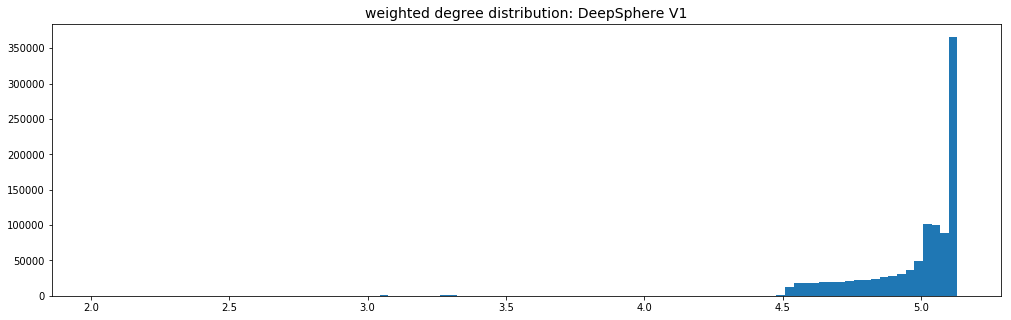

In [9]:
plt.hist(Gold.dw, bins=100)
plt.title('weighted degree distribution: DeepSphere V1', fontsize=14)

Text(0.5,1,'weighted degree distribution: DeepSphere V2\nneighbors=50')

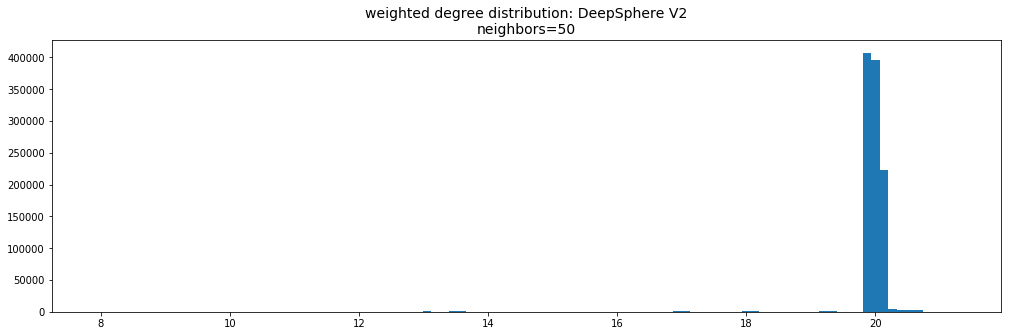

In [10]:
plt.hist(Gnew.dw, bins=100)
plt.title('weighted degree distribution: DeepSphere V2\nneighbors=50', fontsize=14)

In [35]:
Gnew.L.nnz*1*32-np.iinfo(np.int32).max

-417829055

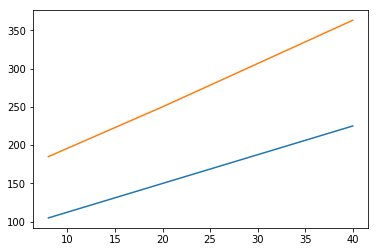

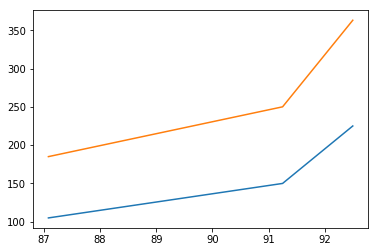

In [101]:
plt.plot([8, 20, 40], [105, 150, 225])
plt.plot([8, 20, 40], [185, 250, 363])
plt.figure()
plt.plot([87.08, 91.25, 92.5], [105, 150, 225])
plt.plot([87.08, 91.25, 92.5], [185, 250, 363])

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


([<matplotlib.axis.XTick at 0x7f8116e2b320>,
 <a list of 3 Text xticklabel objects>)

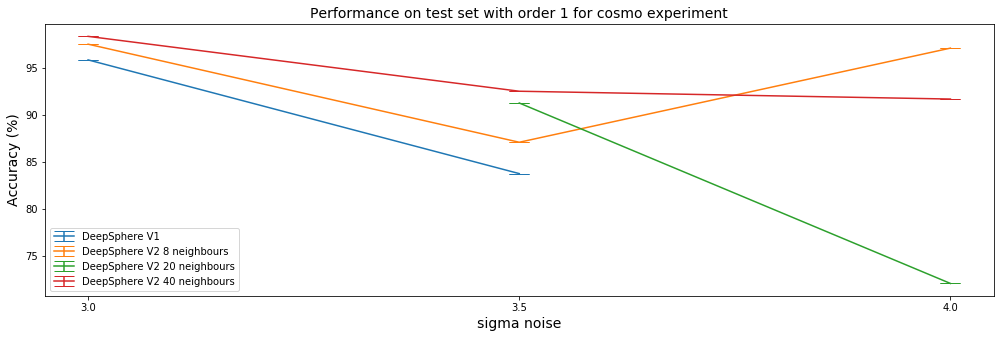

In [93]:
batch_size = 8
batch_time_V1 = [1.49936, 1.48389, 1.53598, 1.55628, 1.474281]
# batch_time_V2_50 = [3.4973, 3.5826, 3.36076]
batch_time_V2_40 = [2.95925, 2.86425, 2.87896]
batch_time_V2_20 = [2.09028, 2.04751, 1.96164, 2.00741, 1.94831, 1.93147716, 1.99608524]
batch_time_V2_8  = [1.47995, 1.48571, 1.48775]
training_time = {"V1": "187 1h45",
                 "V1 CNN": "186 1h45"
#                  "V2 50": "3h10",
                 "V2 40": "363  3h45",
                 "V2 20": "250  2h30",
                 "V2 8":  "185 1h45",}
noise_ = [3, 3.5, 4]# [2, 3, 4, 6, 8]
# new_graph_res = [99.17, np.nan, 94.58, 74.58, 68.33]
new40_graph_res = [[98.33, 92.5, 91.67]]#[98.33, 96.67, 94.17], [np.nan, np.nan, 91.67]]
new20_graph_res = [[np.nan, 91.25, 72.08]]#[95.42, 98.34, 81.67], [np.nan, 91.25, 72.08]]
#                     [[99.58, 99.58, 75.0, 67.92, 66.25], [99.58, np.nan,72.5,66.67,66.25], #[np.nan, np.nan, 71.25, 62.08]
#                    [99.58, np.nan,81.67,54.17,57.5], [100, np.nan, 80.42, 74.58,68.34]]
new8_graph_res = [[97.5, 87.08, 97.08]]#[97.5, 90, 73.34], [94.17, 87.08, 81.67]]
#                 [[99.17, 90.0, 90.42, 62.92, 64.12],[99.58, 98.75, 83.33, 73.75, 63.75], [100, np.nan, 68.34, 69.17, 57.08], 
#                   [100, np.nan, 82.92, 62.92, 57.5]]
old_graph_res = [[95.83, 83.75, np.nan]]#[95.83, 91.25, 71.25], [np.nan, 83.75, np.nan]]
#                 [[99.17, 98.34, 94.58, 61.25, 57.5], [np.nan, np.nan,79.17,62.08,62.08], # ,[99.17, 93.75, 70.42, 70.42]
#                  [100, np.nan, 83.75, 57.5, 61.25], [100, np.nan, 94.58, 75.0, 60.0], [100, np.nan, 72.67, 62.08, np.nan]]
plt.errorbar(noise_, np.nanmean(old_graph_res, axis=0), yerr=np.nanstd(old_graph_res, axis=0), capsize=10,label='DeepSphere V1')
plt.errorbar(noise_, np.nanmean(new8_graph_res, axis=0), yerr=np.nanstd(new8_graph_res, axis=0), capsize=10, label='DeepSphere V2 8 neighbours')
plt.errorbar(noise_, np.nanmean(new20_graph_res, axis=0), yerr=np.nanstd(new20_graph_res, axis=0), capsize=10, label='DeepSphere V2 20 neighbours')
plt.errorbar(noise_, np.nanmean(new40_graph_res, axis=0), yerr=np.nanstd(new40_graph_res, axis=0), capsize=10, label='DeepSphere V2 40 neighbours')
# plt.errorbar(noise_, new_graph_res, yerr=[0, 0, 0, 0, 0], label='DeepSphere V2 50 neighbours')
plt.legend()
plt.xlabel('sigma noise', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Performance on test set with order 1 for cosmo experiment', fontsize=14)
# plt.xlim([2.8,4.2])
plt.xticks([3,3.5,4])

# 2 Solve the problem using histogram features and an SVM classifier

### 2.1 Features compuation and dataset creation
The following function prepare the features for the SVM classifier.
1. It splits the training data into a training and a validation set.
2. It augments the training set by adding different realization of random noise to the sample
3. It computes the histogram features for the training, validation and testing set.
4. It normalizes the features in order for them to have a mean of 0 and a variance of 1.

The features are computed using the function `histogram` of `experiment_helper.py`.

We use 10 different noise realization by setting `augmentation=10` in order to increase the number of training sample.

ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type='histogram', augmentation=10)
features_train, labels_train, features_validation, labels_validation, features_test = ret 

### 2.2  Classification using SVM
Let us test classify our data using an SVM classifier.

error_train, error_validation, C = experiment_helper.err_svc_linear(features_train, labels_train, features_validation, labels_validation)


print('The validation error is {}%'.format(error_validation * 100), flush=True)
print('The Training error is {}%'.format(error_train * 100), flush=True)


We now compute the error on the testing set. To avoid complexity, we do a small mistake that advantage the SVM classifer: we do cross-validation on the testing set.

While this is wrong, the spherical CNN still clearly outperform the SVM classifier.

_, error_test = experiment_helper.err_svc_linear_single(C, features_train, labels_train, features_test, labels_test)

print('The testing error is {}%'.format(error_test * 100), flush=True)

### 2.3 Histogram features visualization

To get a grasp of what is happening, let us plot the histogram of the data.

cmin = np.min(x_raw_train)
cmax = np.max(x_raw_train)
bins = 100
x = np.linspace(cmin,cmax,bins)

fig, axes = plt.subplots(1, 2)
x_hist = experiment_helper.histogram(x_raw_train, cmin, cmax)
plot.plot_with_std(x, x_hist[labels_raw_train==0], color='b', label='class 1', ax=axes[0])
plot.plot_with_std(x, x_hist[labels_raw_train==1], color='r', label='class 2', ax=axes[0])
axes[0].legend()
axes[0].set_title('Histogram - Noiselss case');

if sigma_noise:
    # Updating cmin and cmax does not really affect the features. 
    # We keep the same as in the noisless case in order to have the same x axis.
    x_hist = experiment_helper.histogram(x_raw_train+sigma_noise*np.random.randn(*x_raw_train.shape), cmin, cmax)
    plot.plot_with_std(x, x_hist[labels_raw_train==0], color='b', label='class 1', ax=axes[1])
    plot.plot_with_std(x, x_hist[labels_raw_train==1], color='r', label='class 2', ax=axes[1])
    axes[1].legend()
    axes[1].set_title('Histogram-  Noisy case');


These histogram are normalized in order to get the final features

ax = plot.plot_with_std(features_train[labels_train==0], color='b', label='class 1')
ax = plot.plot_with_std(features_train[labels_train==1], color='r', label='class 2', ax=ax)
ax.legend()
ax.set_title('Histogram features');

# ax = plot.plot_with_std(features_validation[labels_validation==0,:80], color='b', label='class 1')
# ax = plot.plot_with_std(features_validation[labels_validation==1,:80], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('Histogram features - Validation set');

# ax = plot.plot_with_std(features_test[labels_test==0,:80], color='b', label='class 1')
# ax = plot.plot_with_std(features_test[labels_test==1,:80], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('Histogram features - Test set');

# 3 Solve the problem using PSD features and an SVM classifier
Solving the problem with PSD features is very similar than solving it with histogram features. Hence we are not describing each step.

The computation of the PSD features is actually very expensive. Since the classifier will also fail miserably, you may just want to not exectute this part of the notebook. In order to reduce the amount of PSD to be computed, we disable the dataset augementation by setting `augmentation=1`. Nevertheless, we use augmentation for the results in the paper.

ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type='psd', augmentation=1)
features_train, labels_train, features_validation, labels_validation, features_test = ret 

error_train, error_validation, C = experiment_helper.err_svc_linear(features_train, labels_train, features_validation, labels_validation)
print('The validation error is {}%'.format(error_validation * 100), flush=True)
print('The Training error is {}%'.format(error_train * 100), flush=True)

_, error_test = experiment_helper.err_svc_linear_single(C, features_train, labels_train, features_test, labels_test)
print('The testing error is {}%'.format(error_test * 100), flush=True)

### 2.3 PSD features visualization

To get a grasp of what is happening, let us plot the psd features. 

ell = np.arange(features_train.shape[1])
ax = plot.plot_with_std(ell, features_train[labels_train==0], color='b', label='class 1')
ax = plot.plot_with_std(ell, features_train[labels_train==1], color='r', label='class 2', ax=ax)
ax.legend()
ax.set_title('PSD features');
# plt.xscale('log')

# ell = np.arange(features_train.shape[1])
# ax = plot.plot_with_std(ell, features_validation[labels_validation==0], color='b', label='class 1')
# ax = plot.plot_with_std(ell, features_validation[labels_validation==1], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('PSD features - validation dataset');
# # plt.xscale('log')

# ell = np.arange(features_train.shape[1])
# ax = plot.plot_with_std(ell, features_test[labels_test==0], color='b', label='class 1')
# ax = plot.plot_with_std(ell, features_test[labels_test==1], color='r', label='class 2', ax=ax)
# ax.legend()
# ax.set_title('PSD features - testing dataset');
# # plt.xscale('log')

# 4 Classification using Deep Sphere

Let us now classify our data using a spherical convolutional neural network.

### 4.1 Preparation of the dataset
Let us create the datafor the spherical neural network. It is simply the raw data.

In [97]:
ret = experiment_helper.data_preprossing(x_raw_train, labels_raw_train, x_raw_test, sigma_noise, feature_type=None)
features_train, labels_train, features_validation, labels_validation, features_test = ret

Class 1 VS class 2
  Training set: 195 / 189
  Validation set: 45 / 51


The spherical neural network will uses a Dataset object that need to be initialized. The object `LabeledDatasetWithNoise` will add noise to the raw data at the time of training. It will slowly increase the amount of noise during `nit` iteration.

In [155]:
training = LabeledDatasetWithNoise(features_train, labels_train, end_level=sigma_noise)
validation = LabeledDataset(features_validation, labels_validation)

### 4.2 Building the Network

We now create our spherical neural network. We use one architecture, a fully convolutional architecture (see the exact parameters in `hyperparameters.py`), for all the problems (that is for all configurations of `order` and `sigma_noise`. A smaller `order` means more pixels per sample, that is more data for a prediction. It translates to higher accuracy as the network is more confident about its prediction (as they are averaged across spatial locations).

For the paper, we selected a conservative set of parameters that were providing good results across the board. To train faster, diminish `num_epochs`, or interrupt training whenever you get bored. To reproduce all the results from the paper, the easiest is to run the `experiments_deepsphere.py` script.

In [151]:
ntype = 'FCN'
EXP_NAME = 'oldgraph_{}sides_{:0.1f}noise_{}order_{}sigma_{}'.format(Nside, sigma_noise, order, sigma, ntype)

In [13]:
# Cleanup before running again.
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

In [14]:
params = hyperparameters.get_params(training.N, EXP_NAME, order, Nside, ntype)
# params['profile'] = True  # See computation time and memory usage in Tensorboard.
# params['debug'] = True  # Debug the model in Tensorboard.
model = models.deepsphere(**params, new=False)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#samples per batch: 16
Learning rate will start at 2.0e-04 and finish at 4.7e-05.
build laplacian, time:  2.8578410148620605
rescale laplacian, time:  21.98816967010498
build laplacian, time:  22.520158767700195
rescale laplacian, time:  24.76691198348999
build laplacian, time:  24.957375526428223
rescale laplacian, time:  25.347638607025146
build laplacian, time:  25.39183497428894
rescale laplacian, time:  25.51144003868103
build laplacian, time:  25.522844791412354
rescale laplacian, time:  25.560038328170776
build laplacian, time:  25.565006256103516
rescale laplacian, time:  25.576037883758545
NN architecture
  input: M_0 = 1048576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1048576 * 16 / 4 = 4194304
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 262144 * 32 / 4 = 2097152
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    

### 4.3 Find an optimal learning rate (optional)

The learning rate is the most important hyper-parameter. A technique to find an optimal value is to visualize the validation loss while increasing the learning rate. One way to define the optimal learning rate is to search for the largest value looking for which the validation loss still decreases.

In [15]:
# backup = params.copy()
# 
# params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)
# 
# shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
# shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)
# 
# model = models.deepsphere(**params)
# _, loss_validation, _, _ = model.fit(training, validation)
# 
# params.update(backup)
#
# plt.semilogx(learning_rate, loss_validation, '.-')

### 4.4 Training the network

Here are a few remarks.
* The model will create tensorboard summaries in the `summaries` folder. Start tensorboard with `cd summaries` then `tensorboard --logdir .`, and open <http://localhost:6006> in a browser tab to visualize training progress and statistics about the learned parameters. You can debug the model by setting `params['debug'] = True` and launching tensorboard with `tensorboard --logdir . --debugger_port 6064`.
* You probably need a GPU to train the model in an acceptable amount of time.
* You will get slightly different results every time the network is trained.

In [ ]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(training, validation)

training from scratch
step 14 / 1440 (epoch 0.58 / 60):
  learning_rate = 1.97e-04, training mAP = 0.00, training loss = 6.92e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.16e+00
  CPU time: 57s, wall time: 70s, perf_time_load: 1.671s, perf_time: 2.775s
step 28 / 1440 (epoch 1.17 / 60):
  learning_rate = 1.95e-04, training mAP = 0.00, training loss = 5.98e-01
  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.04e+00
  CPU time: 97s, wall time: 125s, perf_time_load: 1.672s, perf_time: 2.771s
step 42 / 1440 (epoch 1.75 / 60):
  learning_rate = 1.92e-04, training mAP = 0.00, training loss = 6.37e-01
  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.17e+00
  CPU time: 130s, wall time: 173s, perf_time_load: 1.696s, perf_time: 2.683s
step 56 / 1440 (epoch 2.33 / 60):
  learning_rate = 1.89e-04, training mAP = 0.00, training loss = 6.18e-01
  validation accuracy: 53.12 (51 / 96), f1 (weighted): 36.86, loss: 1.30e+00
  CPU time: 164s, wall time: 222s, perf_time_load: 1.726s, perf_time: 2.849s
step 70 / 1440 (epoch 2.92 / 60):
  learning_rate = 1.87e-04, t

In [ ]:
# npix = 12*1024**2
# npixel = [npix/(12*o**2) for o in range(1,5)]
# npixel = [npix]+npixel
# npixel = npixel+[12*32**2]
# DeepSphere = [201, 175, 42, 10.3, 2.8, 1.0]
# plt.loglog(npixel, DeepSphere, label='DeepSphere')
# npixel_cohen = [4*bw**2 for bw in [64, 128, 220]]
# t_cohen = [12, 32, 175]
# t_esteves = [9, 16]
# plt.loglog(npixel_cohen, t_cohen, label='Cohen')
# plt.loglog(npixel_cohen[:-1], t_esteves, label='Esteves')
# plt.legend(fontsize=12)
# plt.xlabel('number of pixels', fontsize=15)
# plt.ylabel('Inference speed [s]', fontsize = 15)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.savefig('./figures/cosmo_time.png', bboxes_inches='tight')

We can see below that the classifier does not overfit the training data.

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

In [ ]:
error_validation = experiment_helper.model_error(model, features_validation[:,:,np.newaxis], labels_validation)
print('The validation error is {:.2%}'.format(error_validation), flush=True)

In [ ]:
error_test = experiment_helper.model_error(model, features_test[:,:,np.newaxis], labels_test)
print('The testing error is {:.2%}'.format(error_test), flush=True)

##### validation
noise: 0 . 1 . 2 

error:         83.55 
##### test
noise: 0 . 1 . 2 

error: 99.95 99.24 94.48 89.79 83.16

##### validation
noise: 0 . 1 . 2 

error:     97.14 91.21  84.11 
##### test
noise: 0 . 1 . 2 

error:     96.67  90.39 83.2

## 5 Filters visualization

The package offers a few different visualizations for the learned filters. First we can simply look at the Chebyshef coefficients. This visualization is not very interpretable for human, but can help for debugging problems related to optimization.

layer=2
ind_in = range(6) # Should be None if layer=1
ind_out = range(4)
model.plot_chebyshev_coeffs(layer, ind_in, ind_out)

We observe the Chebyshef polynomials, i.e the filters in the graph spectral domain. This visuallization can help to understand wich graph frequencies are picked by the filtering operation. It mostly interpretable by the people for the graph signal processing community.

model.plot_filters_spectral(layer, ind_in, ind_out);

Here comes one of the most human friendly representation of the filters. It consists the section of the filters "projected" on the sphere. Because of the irregularity of the healpix sampling, this representation of the filters may not look very smooth.

import matplotlib
matplotlib.rcParams.update({'font.size': 16})
model.plot_filters_section(layer, ind_in, ind_out, title='');

Eventually, we can simply look at the filters on sphere. This representation clearly displays the sampling artifacts.

plt.rcParams['figure.figsize'] = (10, 17)
model.plot_filters_gnomonic(layer, ind_in, ind_out, title='');

## 6 Equivariance error

In [6]:
x_raw_train, labels_raw_train, x_raw_std = experiment_helper.get_training_data(sigma, order, data_path=data_path)

In [7]:
x_raw_test, labels_test, _ = experiment_helper.get_testing_data(sigma, order, 4, x_raw_std, data_path=data_path[:-9])

In [8]:
map1 = x_raw_test[:12,:] # full sphere

In [9]:
mapfull = map1.reshape([-1])

In [10]:
import healpy as hp

In [11]:
def transform_shift(data):
    """
    90° rotation around poles (natural Z-axis)
    """
    npix = data.shape[0]
    new_data = data.copy()
    nside = hp.npix2nside(npix)
    theta, _ = hp.pix2ang(nside, range(npix))
    theta_u = np.unique(theta)
    new_data = hp.reorder(data, n2r=True)
    for t in theta_u:
        ligne_ind = np.where(theta==t)[0]
        ligne_ind_roll = np.roll(ligne_ind, len(ligne_ind)//4)
        new_data[ligne_ind_roll] = new_data[ligne_ind]
    new_data = hp.reorder(new_data, r2n = True)
    return new_data

In [12]:
def transform_inverse(data):
    """
    180° rotation around X-axis
    """
    npix = data.shape[0]
    data_c = data.copy()
    new_data = data.copy()
    new_data[:] = -10
    nside = hp.npix2nside(npix)
    theta, _ = hp.pix2ang(nside, range(npix))
    theta_u = np.unique(theta)
    data_c = hp.reorder(data, n2r=True)
    for i, (t, t_end) in enumerate(zip(theta_u, theta_u[::-1])):
        ligne_ind = np.where(theta==t)[0]
        ligne_ind_roll = np.where(theta==t_end)[0][::-1]
        if i > len(theta_u)/4 and i < len(theta_u)*3/4:
            ligne_ind_roll = np.roll(ligne_ind_roll, (i+1)%2)
        new_data[ligne_ind_roll] = data_c[ligne_ind]
    new_data = hp.reorder(new_data, r2n = True)
    return new_data

In [90]:
def rotate_NEST(hmap):
    angles = np.random.uniform(low=0, high=360, size=(5, 3))
    maps = np.zeros((5, hmap.shape[0]))
    for i, [alpha, beta, gamma] in enumerate(angles):
        print("gamma = ", gamma)
        rot = hp.rotator.Rotator(rot=[0, 0, gamma])
        print("rotator")
        maps[i] = hp.reorder(rot.rotate_map_alms(hp.reorder(hmap, n2r=True)), r2n=True)
    return maps


# def _equivariance_error(hmap, max_iter, _filter, lmax, nside):
#     """Calculates the equivariance error on one signal only
#     as average of max_iter random rotations
    
#     hmap is in NEST ordering"""

    
#     angles = np.random.uniform(low=0, high=360, size=(max_iter, 3))
#     norm = np.zeros(max_iter)
    
#     for i, [alpha, beta, gamma] in enumerate(angles):
      
#         rot = hp.rotator.Rotator(rot=[alpha, beta, gamma])
#         R_hmap = rotate_NEST(hmap, rot)
#         FR_hmap = _filter(R_hmap)
#         # ------ first filter, then rotate ------
#         F_hmap = _filter(hmap)
#         RF_hmap = rotate_NEST(F_hmap, rot)
#         norm[i] = np.linalg.norm(RF_hmap-FR_hmap)
            
#     filtered_norm = np.linalg.norm(F_hmap)      
#     return np.mean(norm)/filtered_norm

In [37]:
maprot1 = transform_shift(mapfull)

In [38]:
maprot2 = transform_inverse(mapfull)

In [20]:
maprot3 = mapfull[::-1]

In [14]:
maprots = rotate_NEST(mapfull)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [91]:
maprots_v2 = rotate_NEST(mapfull)

gamma =  180.11823323719233
rotator
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
gamma =  108.28140821209311
rotator
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
gamma =  315.3747893818019
rotator
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
gamma =  136.34463085961255
rotator
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
gamma =  340.13407833803063
rotator
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [39]:
map1_1 = experiment_helper.hp_split(maprot1, order, nest=True)

In [40]:
map1_2 = experiment_helper.hp_split(maprot2, order, nest=True)

In [23]:
map1_3 = experiment_helper.hp_split(maprot3, order, nest=True)

In [23]:
map1_s = [experiment_helper.hp_split(hmap, order, nest=True) for hmap in maprots]

In [28]:
ntype = 'FCN'
EXP_NAME = 'oldgraph_{}sides_{}noise_{}order_{}sigma_8neighbor_{}_fold2'.format(Nside, 4, order, sigma, ntype)

In [29]:
params = hyperparameters.get_params(12, EXP_NAME, order, Nside, ntype)
model = models.deepsphere(**params, new=False)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#samples per batch: 8
Learning rate will start at 2.0e-04 and finish at 1.8e-04.
build laplacian, time:  3.470569610595703
rescale laplacian, time:  84.18893647193909
build laplacian, time:  84.80981469154358
rescale laplacian, time:  120.52814531326294
build laplacian, time:  120.66463041305542
rescale laplacian, time:  122.72026014328003
build laplacian, time:  122.77353191375732
rescale laplacian, time:  123.28990435600281
build laplacian, time:  123.30469369888306
rescale laplacian, time:  123.37114477157593
build laplacian, time:  123.3752794265747
rescale laplacian, time:  123.38908648490906
NN architecture
  input: M_0 = 1048576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1048576 * 16 / 4 = 4194304
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 262144 * 32 / 4 = 2097152
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    b

In [30]:
EXP_NAME = 'cosmo_{}sides_{}noise_{}order_{}sigma_8neighbor_{}_fold2'.format(Nside, 4, order, sigma, ntype)
params = hyperparameters.get_params(12, EXP_NAME, order, Nside, ntype)
model2 = models.deepsphere(**params, new=False)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#samples per batch: 8
Learning rate will start at 2.0e-04 and finish at 1.8e-04.
build laplacian, time:  3.6440980434417725
rescale laplacian, time:  20.764482975006104
build laplacian, time:  21.441349506378174
rescale laplacian, time:  23.86611318588257
build laplacian, time:  24.00617027282715
rescale laplacian, time:  24.32866072654724
build laplacian, time:  24.38049006462097
rescale laplacian, time:  24.519278526306152
build laplacian, time:  24.534762859344482
rescale laplacian, time:  24.57715892791748
build laplacian, time:  24.583576440811157
rescale laplacian, time:  24.61226224899292
NN architecture
  input: M_0 = 1048576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1048576 * 16 / 4 = 4194304
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 262144 * 32 / 4 = 2097152
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    bia

In [31]:
EXP_NAME = 'cosmo_{}sides_{}noise_{}order_{}sigma_20neighbor_{}_fold2'.format(Nside, 4, order, sigma, ntype)
params = hyperparameters.get_params(12, EXP_NAME, order, Nside, ntype)
model3 = models.deepsphere(**params, new=False)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#samples per batch: 8
Learning rate will start at 2.0e-04 and finish at 1.8e-04.
build laplacian, time:  3.4396703243255615
rescale laplacian, time:  19.092151403427124
build laplacian, time:  19.63354182243347
rescale laplacian, time:  21.466327905654907
build laplacian, time:  21.648473024368286
rescale laplacian, time:  22.0504469871521
build laplacian, time:  22.10447072982788
rescale laplacian, time:  22.229648113250732
build laplacian, time:  22.24632978439331
rescale laplacian, time:  22.275291681289673
build laplacian, time:  22.282968044281006
rescale laplacian, time:  22.299227237701416
NN architecture
  input: M_0 = 1048576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1048576 * 16 / 4 = 4194304
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 262144 * 32 / 4 = 2097152
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    bi

In [34]:
EXP_NAME = 'oldgraph_{}sides_{}noise_{}order_{}sigma_8neighbor_{}_fold2'.format(Nside, 4, order, sigma, ntype)
params = hyperparameters.get_params(12, EXP_NAME, order, Nside, ntype)
model_old = models.deepsphere(**params, new=False)

#sides: [1024, 512, 256, 128, 64, 32, 32]
#samples per batch: 8
Learning rate will start at 2.0e-04 and finish at 1.8e-04.
build laplacian, time:  3.255014657974243
rescale laplacian, time:  18.610358715057373
build laplacian, time:  19.20414447784424
rescale laplacian, time:  21.47011423110962
build laplacian, time:  21.644137382507324
rescale laplacian, time:  21.960241079330444
build laplacian, time:  22.01304578781128
rescale laplacian, time:  22.124287128448486
build laplacian, time:  22.140159368515015
rescale laplacian, time:  22.171117782592773
build laplacian, time:  22.175553560256958
rescale laplacian, time:  22.184351205825806
NN architecture
  input: M_0 = 1048576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 1048576 * 16 / 4 = 4194304
    weights: F_0 * F_1 * K_1 = 1 * 16 * 5 = 80
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 262144 * 32 / 4 = 2097152
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    b

In [86]:
vec1 = model2.probs(map1[:,:,np.newaxis], 2)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/cosmo_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


In [67]:
vec1_1 = model_old.probs(map1_1[:,:,np.newaxis], 2)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/oldgraph_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


In [68]:
vec1_2 = model_old.probs(map1_2[:,:,np.newaxis], 2)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/oldgraph_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


In [31]:
vec1_3 = model.probs(map1_3[:,:,np.newaxis], 2)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/oldgraph_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


In [87]:
vec1_s = [model2.probs(hmap[:,:,np.newaxis], 2) for hmap in map1_s]

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/cosmo_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/cosmo_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


In [54]:
desc1 = model3.get_descriptor(map1[:,:,np.newaxis], cache=False)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/cosmo_1024sides_4noise_1order_3sigma_20neighbor_FCN_fold2/model-3840


In [55]:
desc1_1 = model3.get_descriptor(map1_1[:,:,np.newaxis], cache=False)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/cosmo_1024sides_4noise_1order_3sigma_20neighbor_FCN_fold2/model-3840


In [56]:
(desc1[rot90Zindex] == desc1_1).all()

True

In [57]:
desc1_2 = model3.get_descriptor(map1_2[:,:,np.newaxis], cache=False)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/cosmo_1024sides_4noise_1order_3sigma_20neighbor_FCN_fold2/model-3840


In [58]:
np.linalg.norm(desc1[rot180Xindex,::-1,:]-desc1_2)/np.linalg.norm(desc1)

9.88916465686819e-08

In [53]:
np.linalg.norm(desc1[rot180Xindex,::-1,:]-desc1_2)/np.linalg.norm(desc1)

1.147803712119326e-07

In [44]:
rot90Zindex = [1, 2, 3, 0, 5, 6, 7, 4, 9, 10, 11, 8]

In [45]:
rot180Xindex = [11, 10, 9, 8, 4, 7, 6, 5, 3, 2, 1, 0]#[8, 11, 10, 9, 4, 7, 6, 5, 0, 3, 2, 1]

In [46]:
(map1[rot90Zindex] == map1_1).all()

True

In [70]:
np.linalg.norm(vec1[rot90Zindex]-vec1_1)/np.linalg.norm(vec1)

0.0

In [71]:
np.linalg.norm(vec1[rot180Xindex]-vec1_2)/np.linalg.norm(vec1)

0.1009985805257791

In [79]:
np.linalg.norm(vec1[4]-vec1_s[0][4])/np.linalg.norm(vec1[4])

0.11764488394864761

In [85]:
np.linalg.norm(vec1[4]-vec1_s[0][4])/np.linalg.norm(vec1[4])

5.059148963364721e-27

In [89]:
np.linalg.norm(vec1[4]-vec1_s[0][4])/np.linalg.norm(vec1[4])

0.0023637663509929506

In [64]:
np.linalg.norm(vec1-vec1_s[0])/np.linalg.norm(vec1)

0.0036416322901559714

In [88]:
np.linalg.norm(vec1-vec1_s[0])/np.linalg.norm(vec1)

0.0036416322901559714

In [37]:
np.linalg.norm(vec1[::-1]-vec1_3)/np.linalg.norm(vec1)

1.1362659462045955e-23

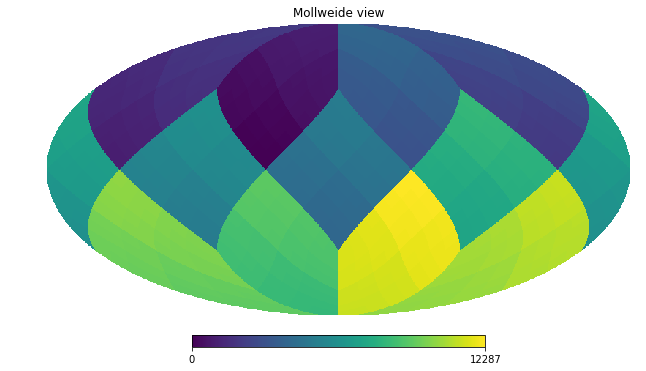

In [56]:
hmaptest = np.arange(12*32**2)
hp.visufunc.mollview(hmaptest, nest=True)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


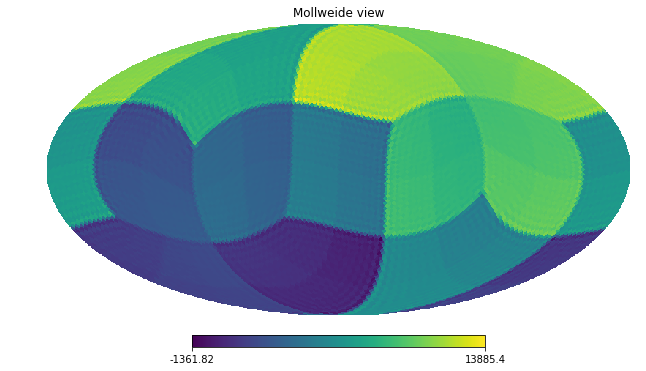

In [57]:
hmaptestrot = rotate_NEST(hmaptest)[0]
hp.visufunc.mollview(hmaptestrot, nest=True)

map1 test, flip 180

erreur equivariance:
* 20 neighbours: 0
* 8 neighbours: 0
* V1: 0.10
* V1 (W threshold à 1): 0

In [126]:
vec1[0]

array([0.86698472, 0.1330152 ])

In [128]:
vec1_2[-1]

array([0.88684368, 0.11315633])

In [129]:
vec1_3[-1]

array([0.88684368, 0.11315633])

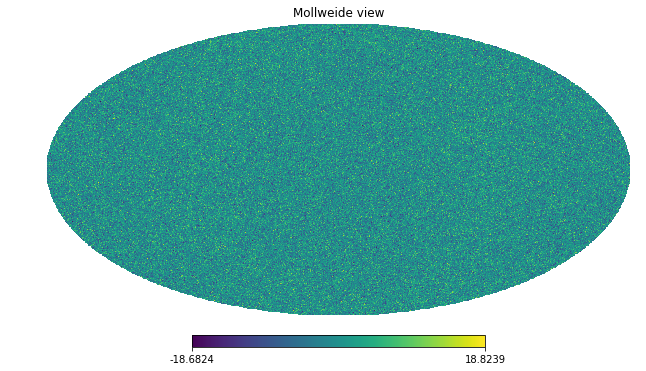

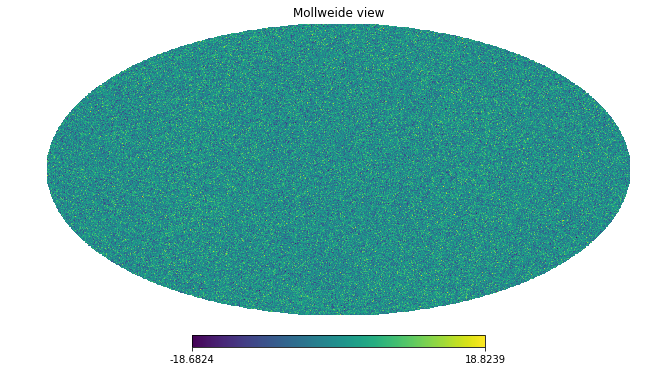

In [135]:
hp.visufunc.mollview(mapfull, nest=True)
# hp.visufunc.mollview(maprot1, nest=True)
hp.visufunc.mollview(maprot2, nest=True)
# hp.visufunc.mollview(maprot3, nest=True)

In [137]:
map1[0] == map1_2[-1][::-1]

array([ True,  True,  True, ...,  True,  True,  True])

In [139]:
model.probs(map1[0][np.newaxis,:,np.newaxis], 2)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/oldgraph_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


array([[0.86698472, 0.1330152 ]])

In [140]:
model.probs(map1[0,::-1][np.newaxis,:,np.newaxis], 2)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/oldgraph_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


array([[0.88684368, 0.11315633]])

In [141]:
model.probs(map1_2[-1][np.newaxis,:,np.newaxis], 2)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/oldgraph_1024sides_4noise_1order_3sigma_8neighbor_FCN_fold2/model-3840


array([[0.88684368, 0.11315633]])